In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
import os

## Read in data from loops

directory_path = r'/Users/rprocious/Waterlevels_CBI/CBI-2/Corrected_Data_Official/nesscanResult_removedBadNesdisRecords/BobHall'
dataframes = []


for filename in sorted(os.listdir(directory_path)):
    if filename.endswith('.csv'):

        file_path = os.path.join(directory_path, filename)
        
        df = pd.read_csv(
        file_path,
        parse_dates=[0],
        na_values=[-999, -99, 99, 'NA', 'RM'],
        engine='python'   
        )
        df.columns = ['station #','date', 'pwl',]
        dataframes.append(df)

bhp = pd.concat(dataframes, ignore_index=True)
bhp['date'] = pd.to_datetime(bhp['date'])

def third_diff(dataset):
    pwl = dataset['pwl']
    third_difference = pwl.shift(3) - 3*pwl.shift(2) + 3*pwl.shift(1) - pwl
    return third_difference.dropna().reset_index(drop=True)

values = third_diff(bhp)
values = round(values,4)
values = values.to_numpy()
nan_array = np.full(3, np.nan)
new_arr = np.concatenate((nan_array, values))
bhp.insert(3,'3D',new_arr)
bhp['Spike flag'] = 0
mean = bhp['3D'].mean()
std = bhp['3D'].std()

outliers = (bhp['3D'] < mean - 5*std) | (bhp['3D'] > mean + 5*std)
bhp.loc[outliers, 'Spike flag'] = 1
bhp['pwl_3D'] = bhp.loc[bhp['Spike flag']==0,'pwl']
bhp

,station #,date,pwl,3D,Spike flag,pwl_3D
0,014,1990-08-21 10:06:00,6.852,NaN,0,6.852
1,014,1990-08-21 10:12:00,6.837,NaN,0,6.837
2,014,1990-08-21 10:18:00,6.840,NaN,0,6.840
3,014,1990-08-21 10:24:00,6.843,0.018,0,6.843
4,014,1990-08-21 10:30:00,6.849,-0.003,0,6.849
...,...,...,...,...,...,...
2591312,014,2020-10-04 23:36:00,7.145,0.007,0,7.145
2591313,014,2020-10-04 23:42:00,7.127,0.011,0,7.127
2591314,014,2020-10-04 23:48:00,7.141,-0.048,0,7.141
2591315,014,2020-10-04 23:54:00,7.129,0.058,0,7.129


In [13]:
import pandas as pd
import numpy as np
import os

# --- Data Loading ---
directory_path = r'/Users/rprocious/Waterlevels_CBI/CBI-2/Corrected_Data_Official/nesscanResult_removedBadNesdisRecords/BobHall'
dataframes = []
for filename in sorted(os.listdir(directory_path)):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(
            file_path,
            parse_dates=[0],
            na_values=[-999, -99, 99, 'NA', 'RM'],
            engine='python'
        )
        df.columns = ['station #', 'date', 'pwl']
        dataframes.append(df)

bhp = pd.concat(dataframes, ignore_index=True)
bhp['date'] = pd.to_datetime(bhp['date'])
cutoff_date = pd.to_datetime('1996-01-01')
bhp = bhp[bhp['date'] >= cutoff_date]
bhp = bhp.reset_index()
median = bhp['pwl'].median()
#threshold = 6

#bhp['pwl'] = bhp['pwl'].where(np.abs(bhp['pwl'] - median) <= threshold, np.nan)

# --- Setup for Two Passes ---
# Create two new columns:
# 1. pwl_initial: after the first (spike) removal pass.
# 2. pwl_manual: after the second (manual) removal pass.
bhp['pwl_initial'] = bhp['pwl']  # start with original data for pass 1
bhp['pwl_manual'] = bhp['pwl']   # will be updated in pass 2

n = len(bhp)
pwl_orig = bhp['pwl'].values  # original water levels as a NumPy array

# --- Pass 1: Initial Spike Removal ---
# Preallocate arrays for the initial third differences and spike flags.
third_diff_initial = np.full(n, np.nan)
spike_flag_initial = np.zeros(n, dtype=int)

# Compute third differences from the original data for indices where a 4-point window is available.
for i in range(3, n):
    window = pwl_orig[i-3:i+1]
    if np.isnan(window).any():
        continue  # skip if any value is missing
    third_diff_initial[i] = window[0] - 3 * window[1] + 3 * window[2] - window[3]

# Set thresholds using non-missing values (mean ± 5×std).
clean_vals = third_diff_initial[~np.isnan(third_diff_initial)]
if clean_vals.size:
    mean_val = clean_vals.mean()
    std_val = clean_vals.std()
    threshold_upper = mean_val + 5 * std_val
    threshold_lower = mean_val - 5 * std_val
else:
    threshold_upper = threshold_lower = None

# Now flag and remove spikes from the first pass.
# (Work on a copy of the original data for this pass.)
pwl_initial = bhp['pwl_initial'].values.copy()
for i in range(3, n):
    window = pwl_initial[i-3:i+1]
    if np.isnan(window).any():
        continue
    third_val = window[0] - 3 * window[1] + 3 * window[2] - window[3]
    if threshold_upper is not None and (third_val > threshold_upper or third_val < threshold_lower):
        spike_flag_initial[i] = 1
        pwl_initial[i] = np.nan  # remove spike by setting the point to NaN

# Save the pass-1 results.
bhp['pwl_initial'] = pwl_initial
bhp['spike_flag_initial'] = spike_flag_initial
bhp['third_diff_initial'] = third_diff_initial

# --- Pass 2: Manual Removal ---
# For the manual pass, we use the pwl_initial output as a constant input.
# This prevents cascading NaNs in later windows.
pwl_initial_in = bhp['pwl_initial'].values.copy()  # constant input for pass 2
pwl_manual = pwl_initial_in.copy()                 # this array will be our manual-pass output
third_diff_manual = np.full(n, np.nan)
manual_flag = np.zeros(n, dtype=int)

# Compute third differences using the pass-1 data.
for i in range(3, n):
    # Always build the 4-point window from the original pass-1 array.
    window = pwl_initial_in[i-3:i+1]
    if np.isnan(window).any():
        manual_flag[i] = 1   # flag for manual review (and removal)
        pwl_manual[i] = np.nan
        continue
    third_diff_manual[i] = window[0] - 3 * window[1] + 3 * window[2] - window[3]

# Save the pass-2 results.
bhp['pwl_manual'] = pwl_manual
bhp['manual_flag'] = manual_flag
bhp['third_diff_manual'] = third_diff_manual


print(bhp.head(20))


     index station #                date    pwl  pwl_initial  pwl_manual  \
0   467717       014 1996-01-01 00:00:00  6.800        6.800       6.800   
1   467718       014 1996-01-01 00:06:00  6.773        6.773       6.773   
2   467719       014 1996-01-01 00:12:00  6.806        6.806       6.806   
3   467720       014 1996-01-01 00:18:00  6.833        6.833       6.833   
4   467721       014 1996-01-01 00:24:00  6.869        6.869       6.869   
5   467722       014 1996-01-01 00:30:00  6.818        6.818       6.818   
6   467723       014 1996-01-01 00:36:00  6.823        6.823       6.823   
7   467724       014 1996-01-01 00:42:00  6.834        6.834       6.834   
8   467725       014 1996-01-01 00:48:00  6.840        6.840       6.840   
9   467726       014 1996-01-01 00:54:00  6.855        6.855       6.855   
10  467727       014 1996-01-01 01:00:00  6.823        6.823       6.823   
11  467728       014 1996-01-01 01:06:00  6.840        6.840       6.840   
12  467729  

In [8]:
bhp.tail(20)

,index,station #,date,pwl,pwl_initial,pwl_manual,spike_flag_initial,third_diff_initial,manual_flag,third_diff_manual
2123580,2591297,014,2020-10-04 22:06:00,7.122,7.122,7.122,0,0.009,0,0.009
2123581,2591298,014,2020-10-04 22:12:00,7.119,7.119,7.119,0,0.009,0,0.009
2123582,2591299,014,2020-10-04 22:18:00,7.133,7.133,7.133,0,-0.025,0,-0.025
2123583,2591300,014,2020-10-04 22:24:00,7.145,7.145,7.145,0,0.019,0,0.019
2123584,2591301,014,2020-10-04 22:30:00,7.135,7.135,7.135,0,0.020,0,0.020
2123585,2591302,014,2020-10-04 22:36:00,7.128,7.128,7.128,0,-0.025,0,-0.025
2123586,2591303,014,2020-10-04 22:42:00,7.117,7.117,7.117,0,0.007,0,0.007
2123587,2591304,014,2020-10-04 22:48:00,7.138,7.138,7.138,0,-0.036,0,-0.036
2123588,2591305,014,2020-10-04 22:54:00,7.150,7.150,7.150,0,0.041,0,0.041
2123589,2591306,014,2020-10-04 23:00:00,7.144,7.144,7.144,0,0.009,0,0.009


In [17]:
bhp['pwl'].idxmax()

1815758

In [18]:
bhp[1815750:1815770]

,index,station #,date,pwl,pwl_initial,pwl_manual,spike_flag_initial,third_diff_initial,manual_flag,third_diff_manual
1815750,2283467,014,2017-02-13 14:24:00,6.423,6.423,6.423,0,0.252,0,0.252
1815751,2283468,014,2017-02-13 14:30:00,6.335,6.335,6.335,0,-0.086,0,-0.086
1815752,2283469,014,2017-02-13 14:36:00,6.466,6.466,6.466,0,-0.253,0,-0.253
1815753,2283470,014,2017-02-13 14:42:00,6.308,6.308,6.308,0,0.508,0,0.508
1815754,2283471,014,2017-02-13 14:48:00,6.499,6.499,6.499,0,-0.638,0,-0.638
1815755,2283472,014,2017-02-13 14:54:00,6.525,6.525,6.525,0,0.514,0,0.514
1815756,2283473,014,2017-02-13 15:00:00,6.469,6.469,6.469,0,-0.083,0,-0.083
1815757,2283474,014,2017-02-13 15:06:00,6.447,6.447,6.447,0,-0.116,0,-0.116
1815758,2283475,014,2017-02-13 15:24:00,15.348,NaN,NaN,1,-8.889,1,NaN
1815759,2283476,014,2017-02-13 15:30:00,6.445,6.445,NaN,0,26.727,1,NaN


In [21]:
bhp[1820035:1820055]

,index,station #,date,pwl,pwl_initial,pwl_manual,spike_flag_initial,third_diff_initial,manual_flag,third_diff_manual
1820035,2287752,014,2017-03-03 12:24:00,6.937,6.937,6.937,0,-0.035,0,-0.035
1820036,2287753,014,2017-03-03 12:30:00,6.922,6.922,6.922,0,0.049,0,0.049
1820037,2287754,014,2017-03-03 12:36:00,6.941,6.941,6.941,0,-0.063,0,-0.063
1820038,2287755,014,2017-03-03 12:42:00,6.938,6.938,6.938,0,0.056,0,0.056
1820039,2287756,014,2017-03-03 12:48:00,6.943,6.943,6.943,0,-0.030,0,-0.030
1820040,2287757,014,2017-03-03 12:54:00,6.947,6.947,6.947,0,0.009,0,0.009
1820041,2287758,014,2017-03-03 13:00:00,6.952,6.952,6.952,0,-0.002,0,-0.002
1820042,2287759,014,2017-03-03 13:06:00,6.945,6.945,6.945,0,0.013,0,0.013
1820043,2287760,014,2017-03-03 13:12:00,14.506,NaN,NaN,1,-7.580,1,NaN
1820044,2287761,014,2017-03-03 13:12:00,6.930,6.930,NaN,0,22.705,1,NaN


Text(0, 0.5, 'Freq')

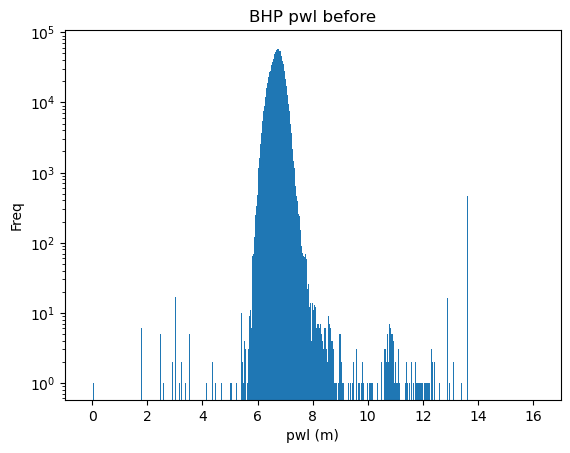

In [14]:
plt.hist(bhp['pwl'],1000)
plt.yscale('log')
plt.xlim(-1,17)
plt.title('BHP pwl before')
plt.xlabel('pwl (m)')
plt.ylabel('Freq')

Text(0, 0.5, 'Freq')

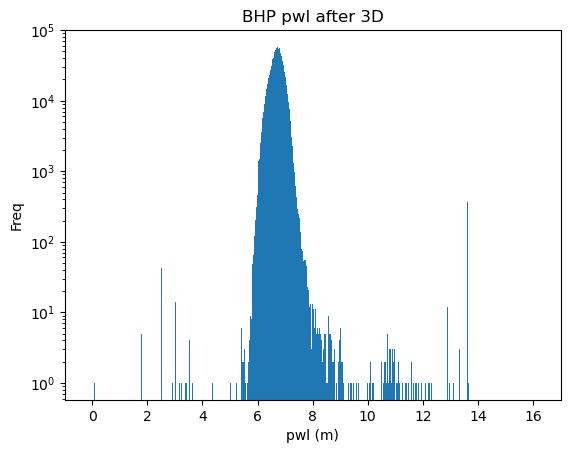

In [15]:
plt.hist(bhp['pwl_initial'],1000)
plt.yscale('log')
plt.xlim(-1,17)
plt.title('BHP pwl after 3D')
plt.xlabel('pwl (m)')
plt.ylabel('Freq')

Text(0, 0.5, 'Freq')

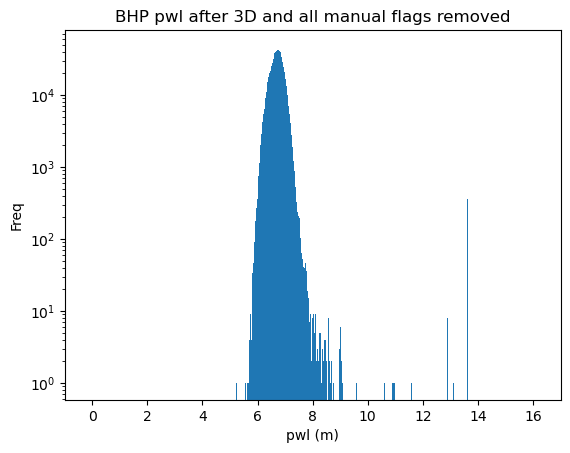

In [16]:
plt.hist(bhp['pwl_manual'],1000)
plt.yscale('log')
plt.xlim(-1,17)
plt.title('BHP pwl after 3D and all manual flags removed')
plt.xlabel('pwl (m)')
plt.ylabel('Freq')

In [22]:
bhp['pwl_manual'].idxmax()

1885702

In [43]:
bhp[1885430:1885450]

,index,station #,date,pwl,pwl_initial,pwl_manual,spike_flag_initial,third_diff_initial,manual_flag,third_diff_manual
1885430,2353147,014,2017-12-07 10:24:00,7.038,7.038,7.038,0,-1.010000e-01,0,-1.010000e-01
1885431,2353148,014,2017-12-07 10:30:00,7.020,7.020,7.020,0,8.400000e-02,0,8.400000e-02
1885432,2353149,014,2017-12-07 10:36:00,7.015,7.015,7.015,0,-4.900000e-02,0,-4.900000e-02
1885433,2353150,014,2017-12-07 10:42:00,6.983,6.983,6.983,0,4.000000e-02,0,4.000000e-02
1885434,2353151,014,2017-12-07 10:48:00,7.012,7.012,7.012,0,-8.800000e-02,0,-8.800000e-02
1885435,2353152,014,2017-12-07 10:54:00,6.997,6.997,6.997,0,1.050000e-01,0,1.050000e-01
1885436,2353153,014,2017-12-07 11:00:00,7.009,7.009,7.009,0,-7.100000e-02,0,-7.100000e-02
1885437,2353154,014,2017-12-07 11:06:00,13.619,NaN,NaN,1,-6.571000e+00,1,NaN
1885438,2353155,014,2017-12-07 11:12:00,13.620,13.620,NaN,0,1.320700e+01,1,NaN
1885439,2353156,014,2017-12-07 11:18:00,13.620,13.620,NaN,0,-6.608000e+00,1,NaN
